# Using Nilearn for analysis of InSpe data in BIDS format

This tutorial is almost identical to tutorial 10 and is based on [this analysis](https://nilearn.github.io/stable/auto_examples/07_advanced/plot_bids_analysis.html).
 and [this analysis](https://nilearn.github.io/dev/auto_examples/00_tutorials/plot_single_subject_single_run.html#sphx-glr-auto-examples-00-tutorials-plot-single-subject-single-run-py) presented on the Nilearn web-page.

In [1]:
import sys
print(sys.executable)
#Check that we have something installed.
import nilearn

/work/807746/emma_folder/virt_env/bin/python3


In [2]:
# Additional imports
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd


# BIDS dataset first and second level analysis


This tutorial contains step-by-step example of fitting a `GLM` to perform a first (single subject) and second level (group)
analysis in a `BIDS` dataset and visualizing the results.

#### Brain Imaging Data Structure (BIDS)
`BIDS`is a particular convention for storing neuroimaging data, which makes it easier to reproduce and share analyses:

![img](https://media.springernature.com/m685/springer-static/image/art%3A10.1038%2Fsdata.2016.44/MediaObjects/41597_2016_Article_BFsdata201644_Fig1_HTML.jpg)

Details about the `BIDS` standard can be consulted at
[http://bids.neuroimaging.io](http://bids.neuroimaging.io/).



## In this tutorial, we will:

1. Download an fMRI `BIDS` dataset with two language conditions to contrast (reading sentences and letter strings).
2. Extract first level (single subject) model objects automatically from the `BIDS` dataset.
3. Investigate the model and plot it design matrix, contrasts and effects.
4. Fit a second level (group) model on the fitted first level models. Notice that
   in this case the preprocessed `BOLD` images were already normalized to the
   same `MNI` space.
5. Plot the results in different ways to show some of the possibilities in Nilearn.


## Fetch InSpe BIDS dataset
The InSpe dataset is located in the `fMRI_data/InSpePosNegData` folder.



### Investigating the BIDS structure
Let's make a function to see what this folder contains.

In [6]:
def list_files(startpath):
    """ Simple function to show directory tree. 
    From: https://stackoverflow.com/questions/9727673/list-directory-tree-structure-in-python. """
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in sorted(files):
            print('{}{}'.format(subindent, f))
            
data_dir='/work/816119/InSpePosNegData/BIDS_2023E/' 
derivatives_dir='/work/816119/InSpePosNegData/BIDS_2023E/derivatives'          
list_files(derivatives_dir)

derivatives/
    .bidsignore
    dataset_description.json
    sub-0116.html
    sub-0117.html
    sub-0118.html
    sub-0119.html
    sub-0120.html
    sub-0121.html
    sub-0122.html
    sub-0123.html
    .ipynb_checkpoints/
        sub-0116-checkpoint.html
        sub-0117-checkpoint.html
    sub-0122/
        func/
            sub-0122_task-boldinnerspeech_run-1_desc-confounds_timeseries.json
            sub-0122_task-boldinnerspeech_run-1_desc-confounds_timeseries.tsv
            sub-0122_task-boldinnerspeech_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.json
            sub-0122_task-boldinnerspeech_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
            sub-0122_task-boldinnerspeech_run-1_from-T1w_to-scanner_mode-image_xfm.txt
            sub-0122_task-boldinnerspeech_run-1_from-scanner_to-T1w_mode-image_xfm.txt
            sub-0122_task-boldinnerspeech_run-1_space-MNI152NLin2009cAsym_boldref.nii.gz
            sub-0122_task-boldinnerspeech_run-1_sp

### What is in the BIDS folder?
This `BIDS` dataset folder contains different mandatory elements ([http://bids.neuroimaging.io](http://bids.neuroimaging.io/)). These include:
- A folder for each participant, e.g. `sub-0121`. This contains a subfolder called `func` where the raw BOLD data is usually stored along with a `.tsv` file describing the events (experimental design) of the particular scan. In this dataset the raw data has been left out. Also the `anat`folder, which normally contains anatomical scans have been left out.
- A folder called `derivatives` which is used to store processed data. In this dataset, we will can find preprocessed data files `preproc_bold.nii` and the `confounds_regressors.tsv` files (which contains the motion parameters from the spatial realignment. 
- A number of `.json` files with meta-data.

NB. All the filenames contain a description of the particular experiment.

## Obtain automatically FirstLevelModel objects and fit arguments
From the dataset directory we automatically obtain the FirstLevelModel objects
with their subject_id filled from the :term:`BIDS` dataset. Moreover, we obtain
for each model a dictionary with run_imgs, events and confounder regressors
since in this case a confounds.tsv file is available in the :term:`BIDS` dataset.
To get the first level models we only have to specify the dataset directory
and the task_label (`languagelocalizer`) as specified in the file names.



In [3]:
from nilearn.glm.first_level import first_level_from_bids

#BIDS directory
data_dir='/work/816119/InSpePosNegData/BIDS_2023E/' 
# BIDS derivatives (contains preprocessed data)
derivatives_dir='/work/816119/InSpePosNegData/BIDS_2023E/derivatives'  

# Name for experiment in the BIDS directory
task_label = 'boldinnerspeech'
# Label for data that are spatially aligned to the MNI152 template (i.e. spatially normalised)
space_label ='MNI152NLin2009cAsym'
#Run the function that can gather all the needed info from a BIDS folder
models, models_run_imgs, models_events, models_confounds = \
    first_level_from_bids(
        data_dir, task_label, derivatives_folder=derivatives_dir, n_jobs=6, verbose=0,
        img_filters=[('desc', 'preproc')])

#Print the data from the first participant as sanity check
print(models_run_imgs[0])

/work/807746/emma_folder/virt_env/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:1148: UserWarning: 'slice_time_ref' provided (0.0) is different from the value found in the BIDS dataset (0.462).
Note this may lead to the wrong model specification.
  warn(


['/work/816119/InSpePosNegData/BIDS_2023E/derivatives/sub-0117/func/sub-0117_task-boldinnerspeech_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/816119/InSpePosNegData/BIDS_2023E/derivatives/sub-0117/func/sub-0117_task-boldinnerspeech_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/816119/InSpePosNegData/BIDS_2023E/derivatives/sub-0117/func/sub-0117_task-boldinnerspeech_run-3_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/816119/InSpePosNegData/BIDS_2023E/derivatives/sub-0117/func/sub-0117_task-boldinnerspeech_run-4_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/816119/InSpePosNegData/BIDS_2023E/derivatives/sub-0117/func/sub-0117_task-boldinnerspeech_run-5_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/work/816119/InSpePosNegData/BIDS_2023E/derivatives/sub-0117/func/sub-0117_task-boldinnerspeech_run-6_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']


### What just happened?
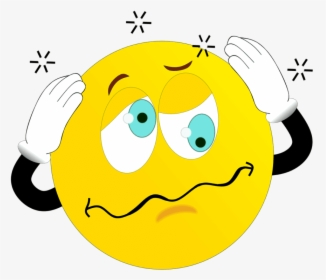

The above code looks somewhat opaque. What is happening here? Let's look into the `first_level_from_bids` function.

## Quick sanity check on arguments
Additional checks or information extraction from pre-processed data can
be made here.



As, we have seen from the folder inspection, we have six run_img per subject.



In [4]:
import os
#Get the file names for subj01 functional data
func01=([os.path.basename(run) for run in models_run_imgs[0]])
print(func01)

['sub-0117_task-boldinnerspeech_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'sub-0117_task-boldinnerspeech_run-2_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'sub-0117_task-boldinnerspeech_run-3_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'sub-0117_task-boldinnerspeech_run-4_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'sub-0117_task-boldinnerspeech_run-5_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'sub-0117_task-boldinnerspeech_run-6_echo-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']


Let's load this file and inspect the data.

In [5]:
from nilearn import image

#Get the full path
func01_path=([os.path.abspath(run) for run in models_run_imgs[0]])
#Load the image and inspect data size
func_img = image.load_img(func01_path)
print("Shape of functional MRI image: %s" % (func_img.shape,))

Shape of functional MRI image: (78, 92, 78, 2940)


As we see, the data contains 6x490 = 2940 volumes with a 78 x 92 x78 voxel resolution.

In [6]:
print(models[0])

FirstLevelModel(n_jobs=6, subject_label='0117', t_r=1)


Here, we see that the model is a `FirstLevelModel` object ([See here for details](https://nilearn.github.io/dev/modules/generated/nilearn.glm.first_level.FirstLevelModel.html)). This means that it incorporates all the same default values for setting up and estimating GLM-fMRI models as in the `first_level_from_bids`, unless else is mentioned. 

Here, we see the additional information that data were obtained with a TR of 1.0 seconds.

fmriprep exports a large number of [confounding parameters](https://fmriprep.org/en/stable/outputs.html#confounds) which can be used to regress out noise in the data. These are saved in a .tsv file in the derivatives folder (func) with the name `sub-00xx_task-boldinnerspeech_run-1_desc-confounds_timeseries.tsv`.

These are automatically imported into the `model_confounds` variable.
Let's inspect what we find in the `models_confounds` variable.

In [7]:
#Print model confounds for first participant, first run
print(models_confounds[0][0].columns)

Index(['global_signal', 'global_signal_derivative1', 'global_signal_power2',
       'global_signal_derivative1_power2', 'csf', 'csf_derivative1',
       'csf_derivative1_power2', 'csf_power2', 'white_matter',
       'white_matter_derivative1',
       ...
       'rot_x_derivative1_power2', 'rot_x_power2', 'rot_y',
       'rot_y_derivative1', 'rot_y_power2', 'rot_y_derivative1_power2',
       'rot_z', 'rot_z_derivative1', 'rot_z_power2',
       'rot_z_derivative1_power2'],
      dtype='object', length=390)


There are literally hundreds of confounds stored.
Read more about them [here](https://fmriprep.org/en/stable/outputs.html#confounds)

Read more about how they can be used in [this article](https://www.sciencedirect.com/science/article/pii/S1053811917310972?via%3Dihub)
Here, we will pick the Friston24 confound variables. These correspond to the rotations and translations, we covered in the <tt>08_fMRI_preprocessing2_spatial.ipyn</tt> tutorial in combination with their derivatives and their squares. We will combine them with four measures of the global signal.

In [8]:
confound_simple = ['trans_x','trans_y','trans_z','rot_x','rot_y','rot_z']

confound_friston24 = ['trans_x','trans_y','trans_z',
                 'rot_x','rot_y','rot_z','trans_x_derivative1','trans_y_derivative1','trans_z_derivative1',
                 'rot_x_derivative1','rot_y_derivative1','rot_z_derivative1','trans_x_power2','trans_y_power2','trans_z_power2',
                 'rot_x_power2','rot_y_power2','rot_z_power2']

confound_friston24_GSR = ['global_signal','global_signal_derivative1','global_signal_power2','global_signal_derivative1_power2','trans_x','trans_y','trans_z',
                 'rot_x','rot_y','rot_z','trans_x_derivative1','trans_y_derivative1','trans_z_derivative1',
                 'rot_x_derivative1','rot_y_derivative1','rot_z_derivative1','trans_x_power2','trans_y_power2','trans_z_power2',
                 'rot_x_power2','rot_y_power2','rot_z_power2']

# Subset confounds with selection
for ii in range(len(models_confounds)):
    confounds1=models_confounds[ii][:].copy()
    for i in range(len(confounds1)):
        confounds2=confounds1[i].copy()
        confounds2=confounds2[confound_simple]
        #Removing NAs in the first row.
        confounds2.loc[0,:]=confounds2.loc[1,:]
        confounds1[i]=confounds2
    models_confounds[ii][:]=confounds1


#Print new confounds, for first participant, first run
print(models_confounds[0][0].columns)

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

Index(['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z'], dtype='object')
Finishing cell: 11:59:33


### Events from the experiment
Next, we will see what is in the `models_events` variable.

In [9]:
print(models_events[0][0])

         onset  duration trial_type cued_word_pos cued_word_neg response  \
0     1.010745  0.685782     IMG_NS        pretty          ugly      NaN   
1     6.313775  0.700187     IMG_NS        pretty          ugly      NaN   
2    12.630463  0.700153     IMG_BI        pretty          ugly        b   
3    16.947486  0.699789     IMG_BI        pretty          ugly        b   
4    23.264478  0.700142     IMG_NS        pretty          ugly      NaN   
..         ...       ...        ...           ...           ...      ...   
85  454.935872  0.700018     IMG_BI        pretty          ugly        b   
86  461.252978  0.699931     IMG_PS        pretty          ugly      NaN   
87  465.569811  0.699926     IMG_PS        pretty          ugly      NaN   
88  469.886653  0.700122     IMG_BI        pretty          ugly        b   
89  474.203819  0.699610     IMG_NS        pretty          ugly        b   

          RT  run   ID             task  
0        NaN    1  117  boldinnerspeech  
1  

We will trim this a bit as well, to avoid some annoying error messages

In [10]:
#Print model confounds for first participant, first run
print(models_events[0][0].columns)

events_sub= ['onset','duration','trial_type']
print(len(models_events))

# Subset model events with selection
for ii in range(len(models_events)):
    events1=models_events[ii][:]
    for i in range(len(events1)):
        events2=events1[i]
        events2=events2[events_sub]
        events1[i]=events2
        #Rename trials to make contrasting easier
        events1[i].replace({'IMG_NS': 'N', 'IMG_PS': 'P', 'IMG_NO': 'N', 'IMG_PO': 'P','IMG_BI': 'B'}, inplace = True)

       
    models_events[ii][:]=events1
  
#Print new confounds, for first participant, first run
print(models_events[1][0].columns)

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

Index(['onset', 'duration', 'trial_type', 'cued_word_pos', 'cued_word_neg',
       'response', 'RT', 'run', 'ID', 'task'],
      dtype='object')
8
Index(['onset', 'duration', 'trial_type'], dtype='object')
Finishing cell: 11:59:57


/tmp/ipykernel_953/3935329650.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events1[i].replace({'IMG_NS': 'N', 'IMG_PS': 'P', 'IMG_NO': 'N', 'IMG_PO': 'P','IMG_BI': 'B'}, inplace = True)
/tmp/ipykernel_953/3935329650.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events1[i].replace({'IMG_NS': 'N', 'IMG_PS': 'P', 'IMG_NO': 'N', 'IMG_PO': 'P','IMG_BI': 'B'}, inplace = True)
/tmp/ipykernel_953/3935329650.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r



We can see check how many trials were in a run:

In [11]:
print(models_events[1][0]['trial_type'].value_counts())

trial_type
N    30
B    30
P    30
Name: count, dtype: int64


90 trials!

## First level (single subject) model estimation
Now, that we have seen that the `first_level_from_bids` function gathers everything we need for analysis, we can get going with the analysis


### Analysing one participant

We will start by analysing the data from the first participant and generating a report of the process and the results.

### Plotting the design matrix
We will then use the `plot_design_matrix`function to give the model a sanity check. 



In [14]:
# Get data and model info for 2nd participant (0117)
model1=models[1]
imgs1=models_run_imgs[1]
events1=models_events[1]
confounds1=models_confounds[1]

#Fit the model - this will also generate a design matrix
model1.fit(imgs1,events1,confounds1)
#model1.zmap=model1.compute_contrast('IMG_BI')

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

/work/807746/emma_folder/virt_env/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:76: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn(
/work/807746/emma_folder/virt_env/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:76: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn(
/work/807746/emma_folder/virt_env/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:76: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn(
/work/807746/emma_folder/virt_env/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:76: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn(


Finishing cell: 12:04:14


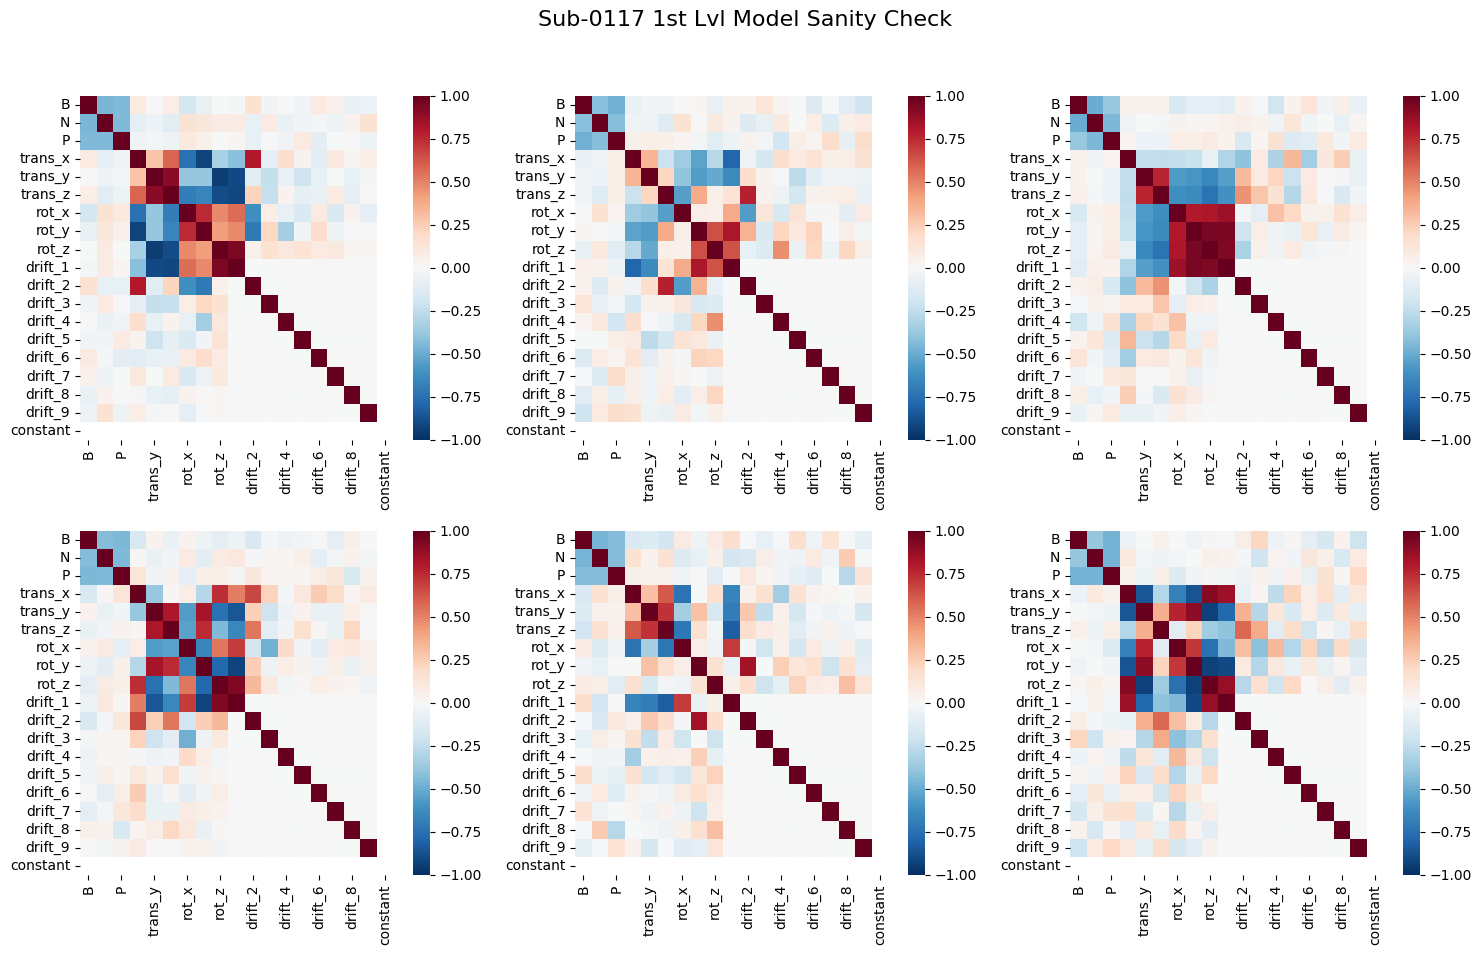

In [15]:
# plot design matric correlation heat map
import matplotlib.pyplot as plt
import seaborn as sns

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Iterate over the design matrices and plot each heatmap
for i in range(6):
    design_matrix = model1.design_matrices_[i]
    sns.heatmap(design_matrix.corr(), vmin=-1, vmax=1, cmap='RdBu_r', ax=axes[i])

# Add a title to the figure
fig.suptitle('Sub-0117 1st Lvl Model Sanity Check', fontsize=16)

# Adjust layout to prevent overlap, accounting for the main title
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the plot to a file
plt.savefig('designmatrix_corr_heatmaps.png', dpi=300)

# Show the plot
plt.show()

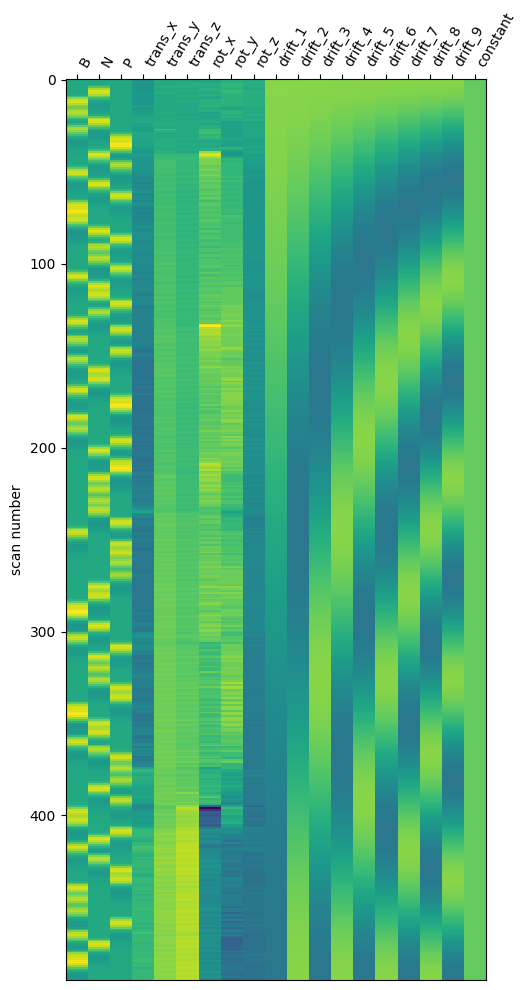

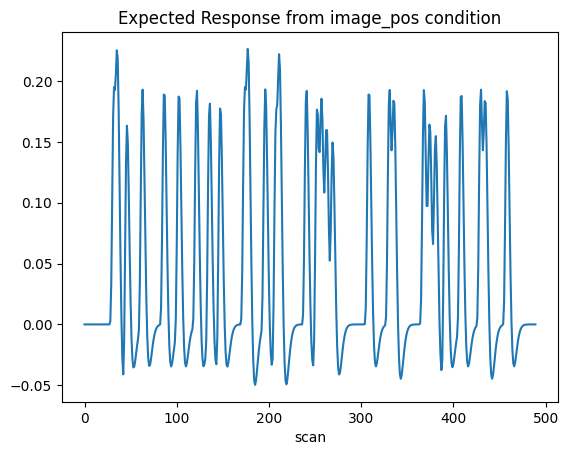

Finishing cell: 12:14:00


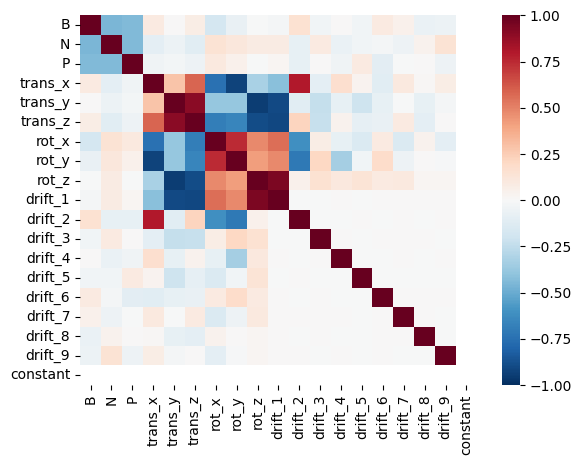

In [28]:
from nilearn.plotting import plot_design_matrix

# View the design matrix from the first session
design_matrix = model1.design_matrices_[0]

#Rename design matrix columns
#design_matrix.rename(columns={"IMG_BI":  "B","IMG_NS": "N", 'IMG_PS': 'P', 'IMG_NO': 'N', 'IMG_PO': 'P'}, inplace = True)

#Plot the design matrix
plot_design_matrix(design_matrix)
plt.show()

# Also plot time series
plt.plot(design_matrix['P'])
plt.xlabel('scan')
plt.title('Expected Response from image_pos condition')
plt.show()


import seaborn as sns
sns.heatmap(design_matrix.corr(), vmin=-1, vmax=1, cmap='RdBu_r')

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

We see that the design matrix contains 2 columns for the conditions + 6 for the motion parameters + 6 cosine functions for high-pass filtering + one constant/intercept.

When plotting the expected response function, we see that it looks like the hemodynamic response function.
#### Fitting the model
If we have a [`FirstLevelModel`](https://nilearn.github.io/dev/modules/generated/nilearn.glm.first_level.FirstLevelModel.html) class object as we have created above, we can use the variable.fit() function to pair the `FirstLevelModel`object with the missing information (e.g. functional images, events and a matrix of confounding variables), assemble the model and estimate it.

### Defining contrasts


Next, we need to specify the `contrasts` that we are interested in. These can be defined using using vectors or the names of of the conditions, specified in the events dataframe. Sum, subtraction and scalar multiplication are allowed.


Finishing cell: 09:24:48


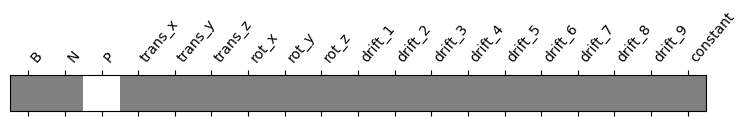

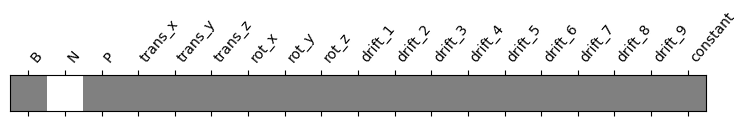

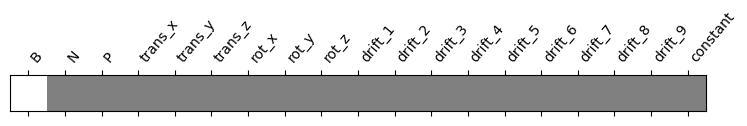

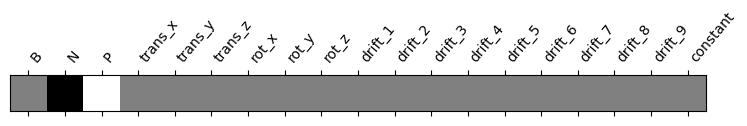

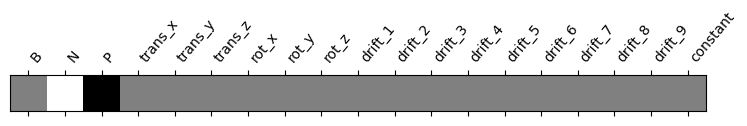

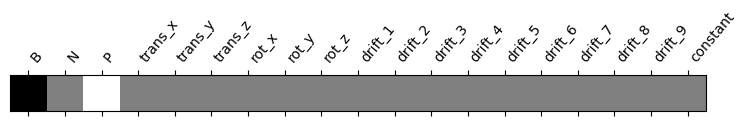

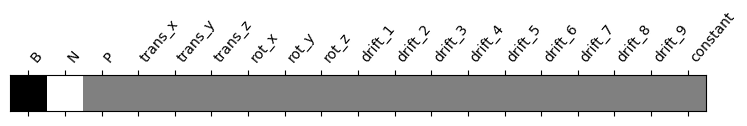

In [35]:
from nilearn.plotting import plot_contrast_matrix

#Define contrasts
contrasts=['P','N','B','P-N','N-P','P-B','N-B']

# Plot them to see what they look like
for contrast in contrasts:
    plot_contrast_matrix(contrast, design_matrix=design_matrix)
    
now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

### Setting the significance threshold
To display the results, we will set a statistical threshold. Conventionally p<0.001, uncorrected for multiple comparisons has been used. 

It often gives a good picture of what is at play in the data, but should be interpreted with caution, due to the fact that it is uncorrected.

In [32]:
from scipy.stats import norm
p001_unc = norm.isf(0.001)

### Plotting the results
Now, we will plot the results from the different contrasts. We will do so using the mean of the functional data as background.

/work/807746/emma_folder/virt_env/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:799: UserWarning: One contrast given, assuming it for all 6 runs
  warn(f"One contrast given, assuming it for all {int(n_runs)} runs")


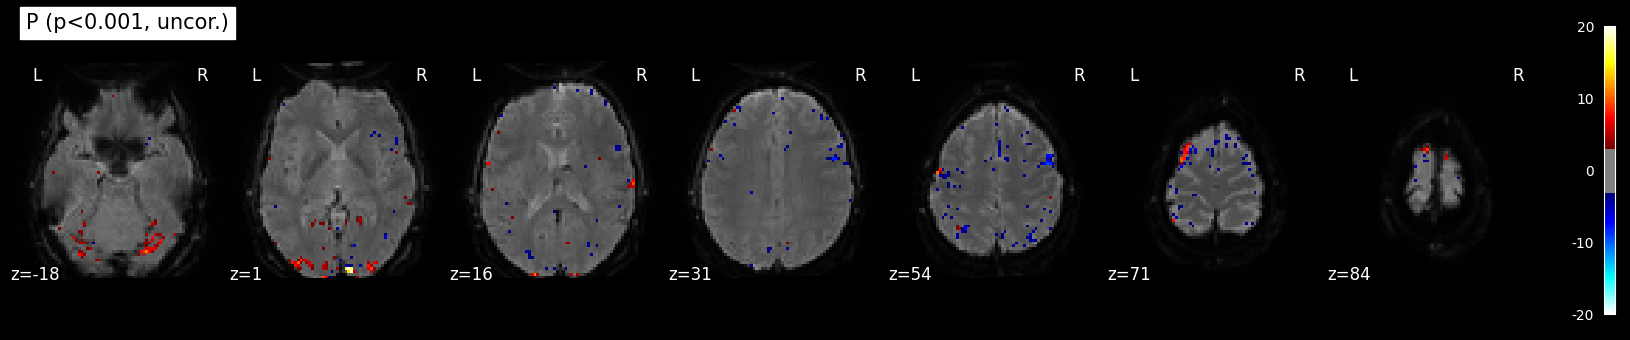

  Cluster ID          X          Y     Z  Peak Stat Cluster Size (mm3)
0          1  -8.089999 -99.662000  -6.0  12.172148                334
1         1a -13.141999 -92.084000   1.5   5.380652                   
2          2 -40.927999 -89.558000  -1.0  11.173709                542
3         2a -33.349999 -94.610000  -1.0  10.156317                   
4         2b -28.297999 -87.032000   4.0   7.230397                   
5          3  24.748001 -79.454000 -18.5  10.753452                829
6         3a  34.852001 -74.401999 -21.0  10.111555                   
7         3b  27.274001 -71.875999 -18.5   4.162717                   
8          4   2.014001 -84.506000  21.5   7.732503                430


/work/807746/emma_folder/virt_env/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:799: UserWarning: One contrast given, assuming it for all 6 runs
  warn(f"One contrast given, assuming it for all {int(n_runs)} runs")


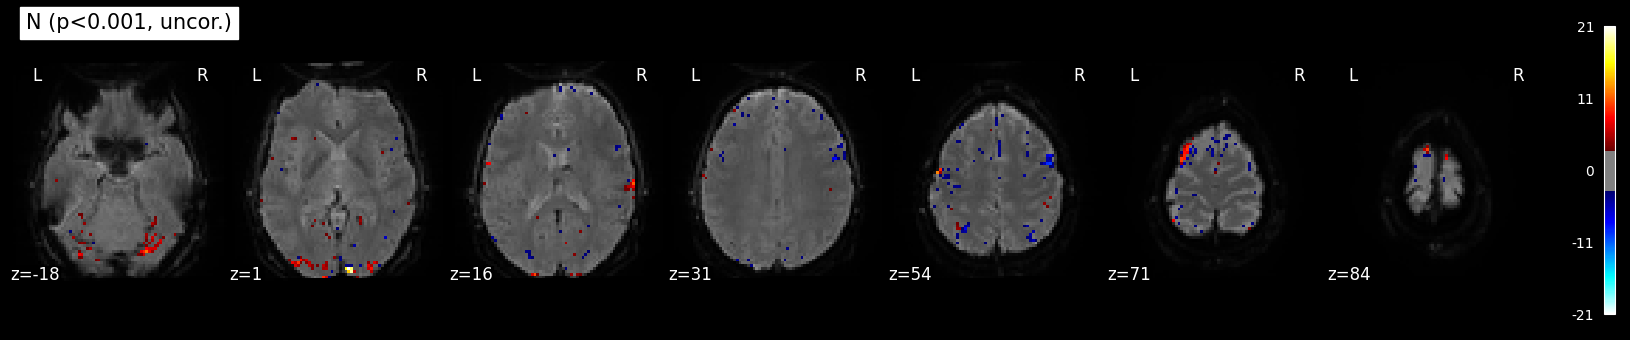

  Cluster ID          X          Y     Z  Peak Stat Cluster Size (mm3)
0          1  -8.089999 -99.662000  -6.0  13.024755                590
1         1a  -0.511999 -87.032000  -6.0   6.735493                   
2         1b -13.141999 -92.084000   1.5   5.618766                   
3          2  24.748001 -79.454000 -18.5  11.535211               1100
4         2a  37.378001 -71.875999 -21.0  10.668912                   
5         2b  17.170001 -84.506000 -13.5   7.700004                   
6         2c  44.956001 -66.823999 -21.0   4.913552                   
7          3 -40.927999 -89.558000  -1.0  10.731731                446
8         3a -28.297999 -87.032000   1.5   6.250360                   
9          4   2.014001 -81.980000  21.5   8.410014                430


/work/807746/emma_folder/virt_env/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:799: UserWarning: One contrast given, assuming it for all 6 runs
  warn(f"One contrast given, assuming it for all {int(n_runs)} runs")


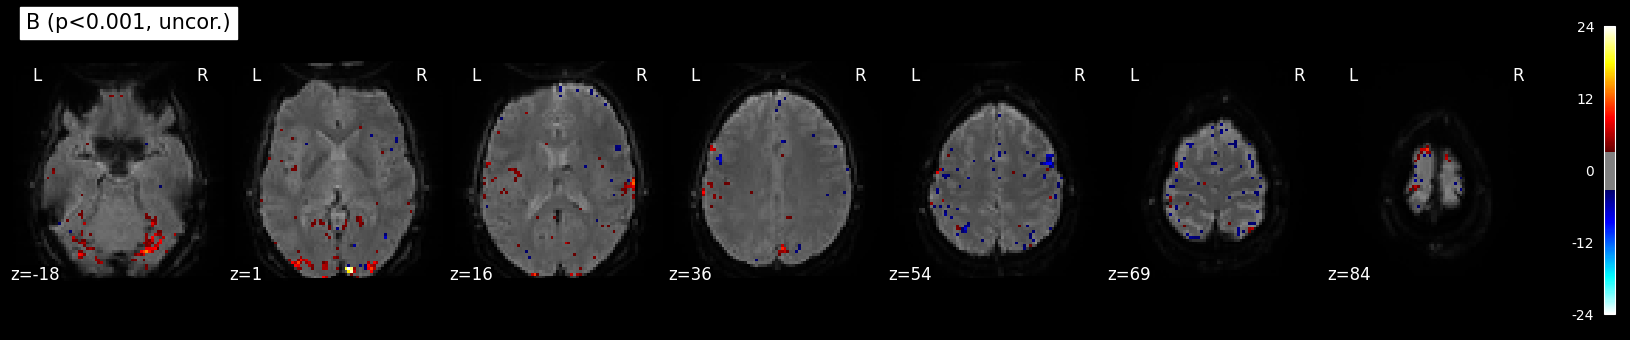

   Cluster ID          X          Y     Z  Peak Stat Cluster Size (mm3)
0           1   9.592001 -94.610000   1.5  23.527256                478
1           2  24.748001 -79.454000 -18.5  13.305237               1611
2          2a  34.852001 -74.401999 -21.0  12.056185                   
3          2b  17.170001 -84.506000 -13.5  10.592297                   
4          2c  29.800001 -66.823999 -18.5   8.310924                   
5           3  -8.089999 -99.662000  -6.0  12.576336                414
6          3a -13.141999 -92.084000   1.5   5.836680                   
7           4  67.690001 -18.829999  16.5  11.971559                382
8          4a  60.112001 -28.933999  14.0   4.399594                   
9           5 -33.349999 -94.610000  -1.0  11.777189                654
10         5a -40.927999 -89.558000  -1.0  11.587653                   
11         5b -28.297999 -87.032000   4.0   7.118459                   
12          6  29.800001 -94.610000   1.5  10.787598            

/work/807746/emma_folder/virt_env/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:799: UserWarning: One contrast given, assuming it for all 6 runs
  warn(f"One contrast given, assuming it for all {int(n_runs)} runs")


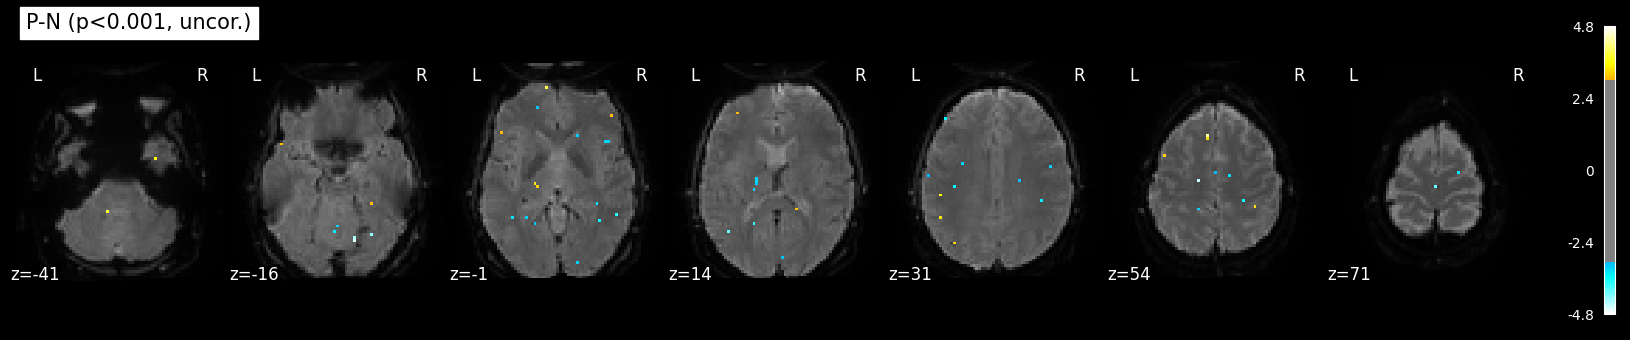

/work/807746/emma_folder/virt_env/lib/python3.9/site-packages/nilearn/reporting/_get_clusters_table.py:339: UserWarning: Attention: No clusters with stat higher than 3.090232306167813
  warnings.warn(
/work/807746/emma_folder/virt_env/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:799: UserWarning: One contrast given, assuming it for all 6 runs
  warn(f"One contrast given, assuming it for all {int(n_runs)} runs")


Empty DataFrame
Columns: [Cluster ID, X, Y, Z, Peak Stat, Cluster Size (mm3)]
Index: []


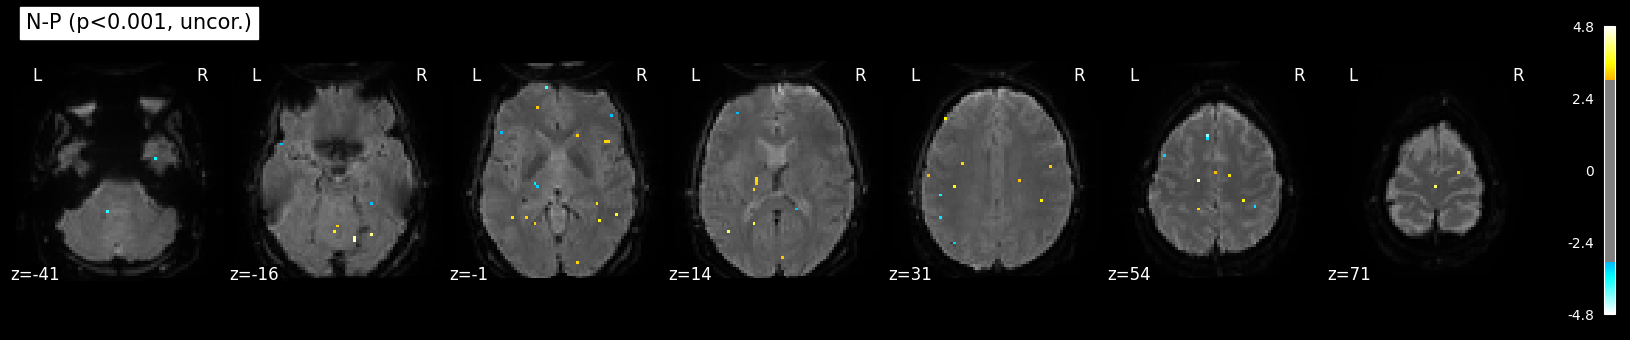

/work/807746/emma_folder/virt_env/lib/python3.9/site-packages/nilearn/reporting/_get_clusters_table.py:339: UserWarning: Attention: No clusters with stat higher than 3.090232306167813
  warnings.warn(
/work/807746/emma_folder/virt_env/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:799: UserWarning: One contrast given, assuming it for all 6 runs
  warn(f"One contrast given, assuming it for all {int(n_runs)} runs")


Empty DataFrame
Columns: [Cluster ID, X, Y, Z, Peak Stat, Cluster Size (mm3)]
Index: []


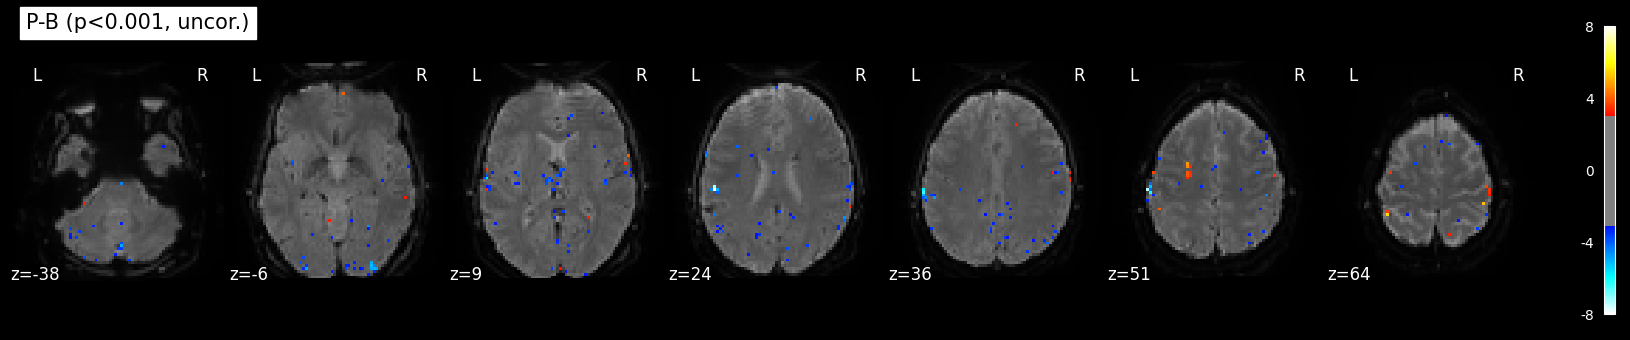

/work/807746/emma_folder/virt_env/lib/python3.9/site-packages/nilearn/reporting/_get_clusters_table.py:339: UserWarning: Attention: No clusters with stat higher than 3.090232306167813
  warnings.warn(
/work/807746/emma_folder/virt_env/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:799: UserWarning: One contrast given, assuming it for all 6 runs
  warn(f"One contrast given, assuming it for all {int(n_runs)} runs")


Empty DataFrame
Columns: [Cluster ID, X, Y, Z, Peak Stat, Cluster Size (mm3)]
Index: []


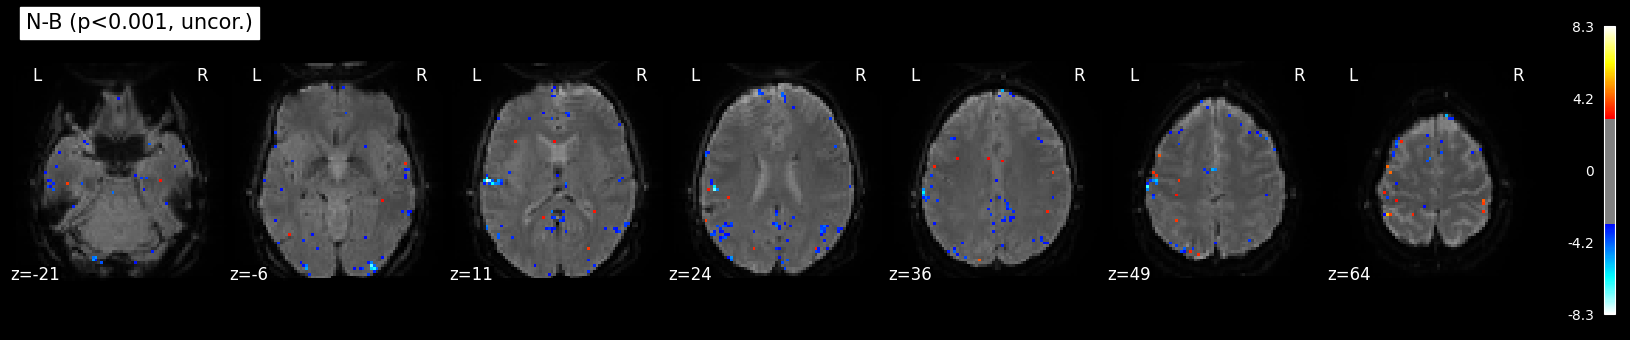

Empty DataFrame
Columns: [Cluster ID, X, Y, Z, Peak Stat, Cluster Size (mm3)]
Index: []
Finishing cell: 09:20:42


/work/807746/emma_folder/virt_env/lib/python3.9/site-packages/nilearn/reporting/_get_clusters_table.py:339: UserWarning: Attention: No clusters with stat higher than 3.090232306167813
  warnings.warn(


In [33]:
from nilearn.plotting import plot_stat_map
from nilearn.reporting import get_clusters_table
from nilearn.image import mean_img

# Make a mean image for display purposes
mean_img_ = mean_img(imgs1)

for contrast in contrasts:
    z_map = model1.compute_contrast(contrast, output_type='z_score')


    titlex=''.join([contrast, ' ', '(p<0.001, uncor.)'])
    plot_stat_map(z_map, bg_img=mean_img_, threshold=p001_unc,
              display_mode='z',  black_bg=True,
              title=titlex)
    plt.show()
    
    # Make a table of cluster coordinates.
    table = get_clusters_table(z_map, stat_threshold=p001_unc,
                           cluster_threshold=20)
    print(table)
    
now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

### Make a report of the results

We can also use the [`make_glm_report`](https://nistats.github.io/modules/generated/nistats.reporting.make_glm_report.html) function to make a report in one go. This report is generated as a HTML document, which can only be viewed in a notebook.

This also includes a table of cluster coordinates.


In [34]:
from nilearn.reporting import make_glm_report
#Generate a report
report = make_glm_report(model1,
                         contrasts=contrasts,
                         threshold=p001_unc,
                         bg_img=mean_img_,
                         )
#Display report in HTML format
report

/work/807746/emma_folder/virt_env/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:799: UserWarning: One contrast given, assuming it for all 6 runs
  warn(f"One contrast given, assuming it for all {int(n_runs)} runs")


### Making an F contrast


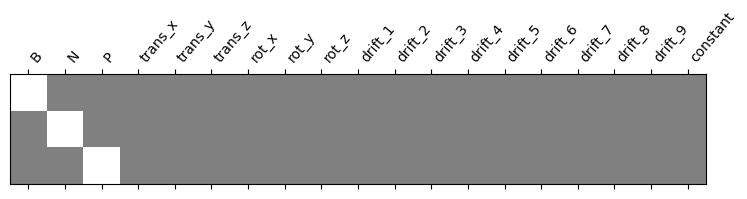

/work/807746/emma_folder/virt_env/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:799: UserWarning: One contrast given, assuming it for all 6 runs
  warn(f"One contrast given, assuming it for all {int(n_runs)} runs")
/work/807746/emma_folder/virt_env/lib/python3.9/site-packages/nilearn/glm/contrasts.py:381: UserWarning: Running approximate fixed effects on F statistics.
  warn("Running approximate fixed effects on F statistics.")


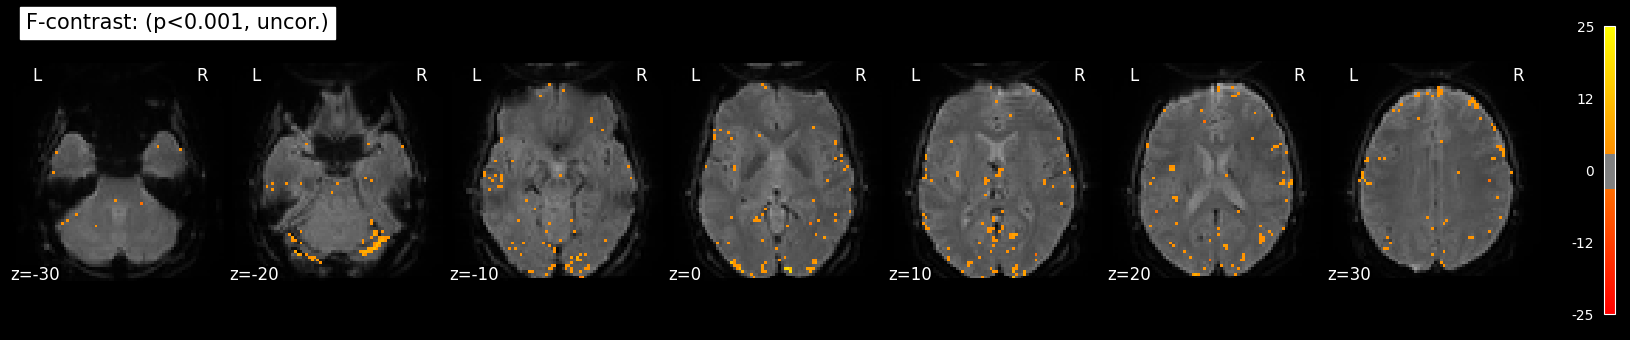

   Cluster ID          X           Y     Z  Peak Stat Cluster Size (mm3)
0           1   9.592001  -94.610000   1.5  24.601245                797
1          1a  12.118001  -89.558000 -13.5   5.192942                   
2           2  -8.089999  -99.662000  -6.0  13.684185                366
3          2a -13.141999  -92.084000   1.5   5.565895                   
4           3  24.748001  -79.454000 -18.5  13.205226                861
5          3a  34.852001  -74.401999 -21.0  11.903784                   
6          3b  44.956001  -66.823999 -21.0   4.668853                   
7          3c  27.274001  -71.875999 -18.5   4.268129                   
8           4 -45.980000   -3.673999  61.5  12.936080                606
9          4a -53.558000   -8.725999  54.0  12.009710                   
10         4b -38.401999   -1.147999  66.5   9.817089                   
11         4c -58.610000   -6.199999  46.5   9.079493                   
12          5 -40.927999  -89.558000  -1.0  12.3002

In [36]:
import numpy as np

#create a contrast matrix for the F-contrast, spanning the three first columns in the design matrix
effects_of_interest =np.identity(design_matrix.shape[1])[[0,1,2],:]

#Let's see what it looks like
plot_contrast_matrix(effects_of_interest, design_matrix)
plt.show()

#Similar to above, we will compute the effect
z_map = model1.compute_contrast(effects_of_interest,
                                  output_type='z_score')

#And plot the results using an overlay
plot_stat_map(z_map, bg_img=mean_img_, threshold=p001_unc, cmap='autumn',
              display_mode='z',  black_bg=True,cut_coords=[-30,-20,-10,0,10,20,30],
              title='F-contrast: (p<0.001, uncor.)')
plt.show()
    
# Make a table of cluster coordinates.
table = get_clusters_table(z_map, stat_threshold=p001_unc,
                           cluster_threshold=20)
print(table)

### Analysing all single participants in one go and plotting them

Now, we will make a loop which fits all the models and plots the results. We will focus on the `image_neg-image_pos` contrast.



/work/807746/emma_folder/virt_env/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:76: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn(
/work/807746/emma_folder/virt_env/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:76: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn(
/work/807746/emma_folder/virt_env/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:799: UserWarning: One contrast given, assuming it for all 6 runs
  warn(f"One contrast given, assuming it for all {int(n_runs)} runs")
/work/807746/emma_folder/virt_env/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:76: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn(
/work/807746/emma_folder/virt_env/lib/python3.9/site-packages/nilearn/glm/first_level/first_

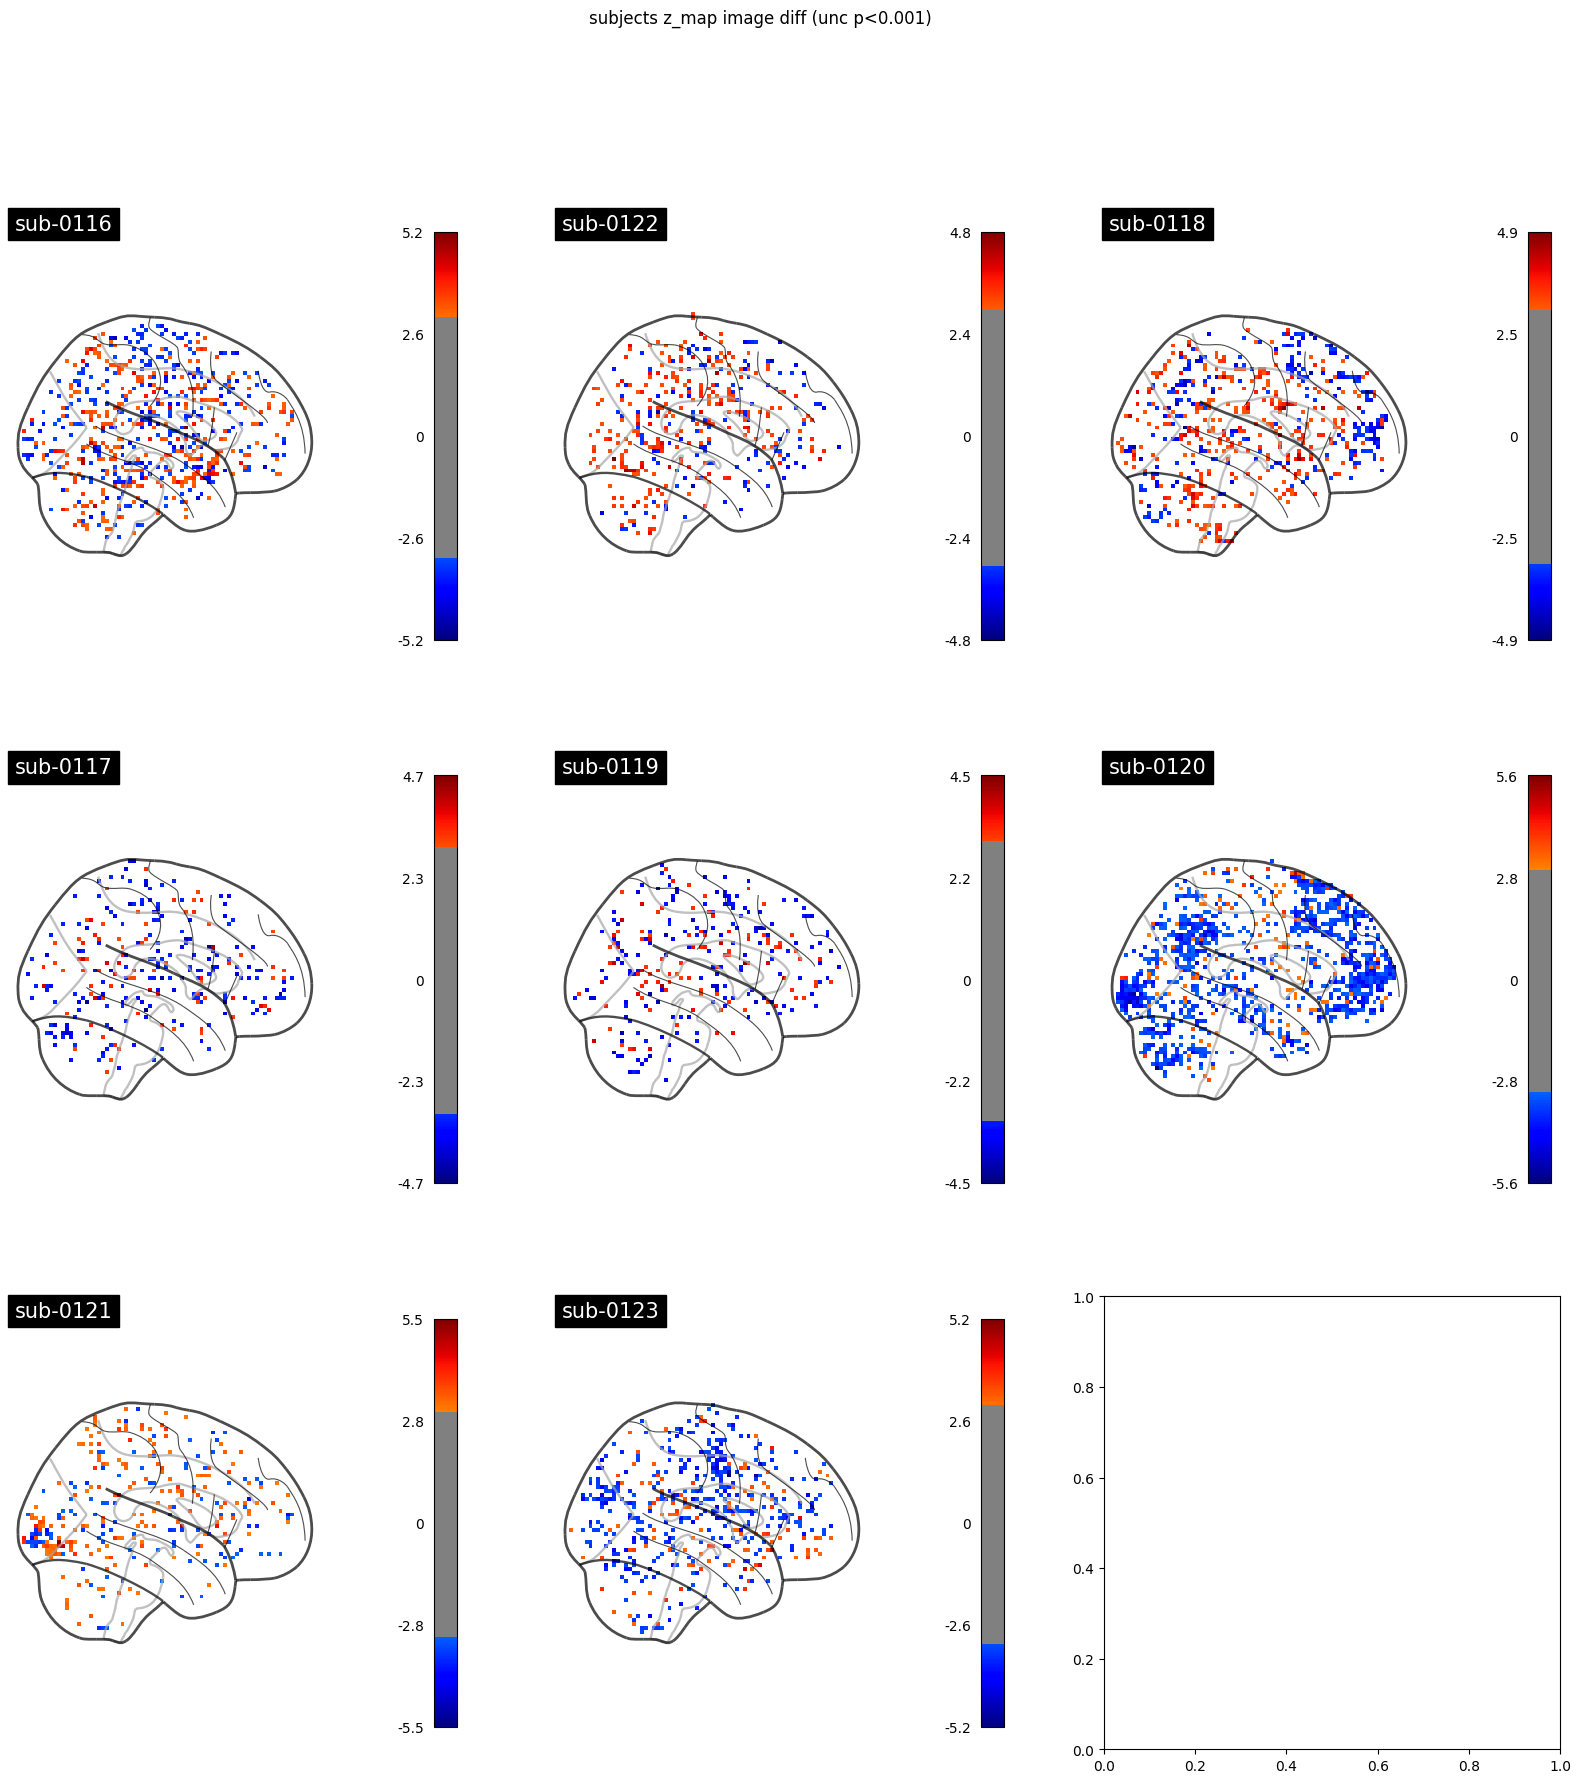

Finishing cell: 10:17:44


In [48]:
from nilearn import plotting
import matplotlib.pyplot as plt

#now = datetime.now()
#print('Starting cell:',now.strftime("%H:%M:%S"))

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20)) 
model_and_args = zip(models, models_run_imgs, models_events, models_confounds)

for m_idx, (model, imgs, events, confounds) in enumerate(model_and_args):
    # fit the GLM, recall that the model variable is a FirstLevelModel object
    model.fit(imgs, events, confounds)
    # compute the contrast of interest and make a map of z-values
    model.zmap = model.compute_contrast('N-P')
    #Plot each thresholded analysis
    plotting.plot_glass_brain(model.zmap, cmap='jet',colorbar=True, threshold=p001_unc,
                              title=('sub-' + model.subject_label),
                              axes=axes[int(m_idx / 3), int(m_idx % 3)],
                              plot_abs=False, display_mode='x')   
fig.suptitle('subjects z_map image diff (unc p<0.001)')
plotting.show()

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

#### Same but different
Note that the single subject results look very different, although one can also see patterns in most participants that look similar.

## Saving results.

The analysis took a bit of time. Let's make sure to save the results, so that we don't have to run that again. 

#### Remember to change the directory to somewhere convenient.

In [49]:
import pickle
#Save the first level models
# Saving the objects:
f = open('/work/807746/emma_folder/notebooks/fMRI/project_repo/notebooks/flms/InSpe_first_level_models.pkl','wb')
pickle.dump([models, models_run_imgs, models_events, models_confounds], f)
f.close()

# Getting back the objects:
#f = open('/work/807746/emma_folder/notebooks/fMRI/project_repo/notebooks/flms/InSpe_first_level_models.pkl','rb')
#models, models_run_imgs, models_events, models_confounds = pickle.load(f)
#f.close()

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

Finishing cell: 10:19:20


## Second level (group) model estimation

To investigate the degree of overlap in the data, we will perform a 2nd level analysis, where the contrast estimates for each individual participant will enter as data in a new statistical test.

We just have to provide the list of fitted FirstLevelModel objects
to the SecondLevelModel object for estimation. We can do this because
all subjects share a similar design matrix (same variables reflected in
column names).



In [47]:
from nilearn.glm.second_level import SecondLevelModel
#We will simply add the models estimated above to the second level

#second_level_input = models
second_level_input = models

#Adding the smoothing parameter
second_level_model = SecondLevelModel(smoothing_fwhm=8.0)
second_level_model = second_level_model.fit(second_level_input)

print(second_level_model)

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

IndexError: list index out of range

Note that we apply a smoothing of 8mm.



Computing contrasts at the second level is as simple as at the first level.
Since we are not providing confounders we are performing a one-sample test
at the second level with the images determined by the specified first level
contrast.



In [11]:
# NB, variable names used in contrasts have to be the same as those in events file.
zmap_g = second_level_model.compute_contrast(
    first_level_contrast='N-P')

/work/798873/virt_env/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:706: UserWarning: One contrast given, assuming it for all 6 runs
  warn(f'One contrast given, assuming it for all {int(n_runs)} runs')


The group level contrast shows...


In [ ]:
from nilearn import plotting
from nilearn.plotting import plot_stat_map
import scipy.stats as st
import matplotlib

plotting.plot_glass_brain(zmap_g, cmap='PiYG',colorbar=True, threshold=None,
                          title='Group [neg-pos] effect (unthresholded)',
                          plot_abs=False)
plt.show()

#Uncorrected threshold p<0.001, uncorrected using the standardised normal distribution
p001uncor=st.norm.ppf(.9999)

plotting.plot_glass_brain(zmap_g, cmap='PiYG',colorbar=True, threshold=p001uncor,
                          title='Group [neg-pos] effect (unc p<0.001)',
                          plot_abs=False)
plt.show()

plot_stat_map(zmap_g, cmap='PiYG',threshold=p001uncor, cut_coords=[-30,-20,-10,0,10,20,30],
              display_mode='z',  black_bg=False,
              title='Group [neg-pos] effect (unc p<0.001)')
plt.show()

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

/work/798873/virt_env/lib/python3.10/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 4.819418071592575. But, you have given threshold=5.035192853912386 
  warnings.warn(


The p<.05 FWER-corrected threshold is 5.04


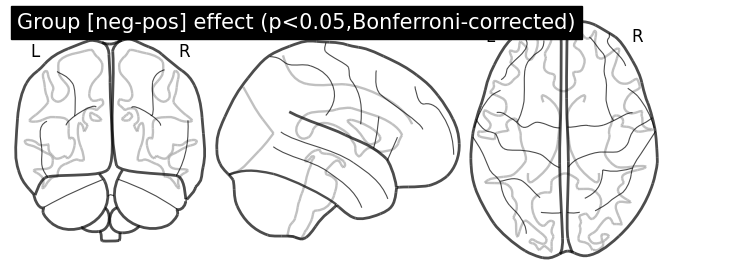

NameError: name 'get_clusters_table' is not defined

In [38]:
from nilearn.glm import threshold_stats_img

thresholded_map, threshold = threshold_stats_img(
    zmap_g, alpha=0.05, height_control='bonferroni')
print('The p<.05 FWER-corrected threshold is %.3g' % threshold)

plotting.plot_glass_brain(zmap_g, cmap='PiYG',colorbar=True, threshold=threshold,
                          title='Group [neg-pos] effect (p<0.05,Bonferroni-corrected)',
                          plot_abs=False)
plt.show()

# Make a table of cluster coordinates.
table = get_clusters_table(zmap_g, stat_threshold=threshold)
print(table)

### Find anatomical labels for peak activations
We will use a function called [atlasreader](https://github.com/miykael/atlasreader).

In [23]:
from atlasreader import create_output
create_output(zmap_g, voxel_thresh=threshold, cluster_extent=0,direction='both')
#Atlasreader automatically saves results to both .png-files and a csv-file. Look in your working directory.
pd.read_csv('atlasreader_peaks.csv')

ModuleNotFoundError: No module named 'atlasreader'

As can be seen, the fdr correction may be too lenient, and the FWE correction may be too stringent.

## Non-parametric permutation methods for calculating corrected p-values

Based on [this](https://nilearn.github.io/dev/auto_examples/05_glm_second_level/plot_second_level_one_sample_test.html#sphx-glr-auto-examples-05-glm-second-level-plot-second-level-one-sample-test-py) example.

Permutation tests are a class of non-parametric methods. They were pioneered by Fisher (1935) and Pitman (1937). Fisher demonstrated that the null hypothesis could be tested simply by observing, after permuting observations, how often the difference between means would exceed the difference found without permutation, and that for such test, no normality would be required.


![permutation_stats.jpg](images/permutation_stats.jpg)

If we are comparing two samples (e.g. `treatment` and `control`), we can calculate the effect, we get when shuffling the category labels.

![Permutation_test_example_animation.gif](images/Permutation_test_example_animation.gif)
Source:[Wikipedia](https://en.wikipedia.org/wiki/Permutation_test)

The percentage of values we get that are bigger than our original value, represents the probability that our value comes from the null-distribution.

The one-sided p-value of the test is calculated as the proportion of sampled permutations where the difference in means was greater than ${\displaystyle T_{\text{obs}}}$. 
The two-sided p-value of the test is calculated as the proportion of sampled permutations where the absolute difference was greater than 
${\displaystyle |T_{\text{obs}}|}$.

When conducting a one-sample group analysis with fMRI-data, we are testing ${\displaystyle H_{0}:T=0}$, i.e.  if the effect of any given voxel is larger than zero. We can obtain a null-distribution by estimating the effect N times, while randomly flipping the sign on each datapoint.

### Making a an image for comparison
Before we make the permutation test, we'll calculate an image from the parametric analysis for comparison. We will use the negative log of the p-value as a measure.


In [24]:
import numpy as np
from nilearn.image import get_data, math_img

#Get an image of p-values
p_val = second_level_model.compute_contrast(first_level_contrast='N-P',output_type='p_value')
# Get the number of voxels in the image
n_voxels = np.sum(get_data(second_level_model.masker_.mask_img_))
# Making an image with significant values, correcting the p-values for multiple testing and taking negative logarithm
neg_log_pval = math_img(
    '-np.log10(np.minimum(1, img * {}))'.format(str(n_voxels)),
    img=p_val,
)

#Check image shape
print(neg_log_pval.shape)

/work/798873/virt_env/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:706: UserWarning: One contrast given, assuming it for all 6 runs
  warn(f'One contrast given, assuming it for all {int(n_runs)} runs')


(78, 92, 78)


<string>:1: RuntimeWarning: divide by zero encountered in log10


### Next, we perform the permutations.

In [29]:
from nilearn.glm.second_level import non_parametric_inference

now = datetime.now()
print('Starting cell:',now.strftime("%H:%M:%S"))

# n_perm=1000 for the sake of time. Ideally, this should be 10,000, but the upper limit on permutations is 2 to the power of N.
n_perm=10000

#We base the analysis on a contrast image (z-score map) from each participant
second_level_input2=[]
#Put the NIimg zmaps into a list.
for ii in range(8):
    second_level_input2.append(second_level_input[ii].zmap)

design_matrix = pd.DataFrame(
    [1] * len(second_level_input2),
    columns=['intercept'],
)
print(design_matrix)

#Calculate p-values using permutation
out_dict = non_parametric_inference(
    second_level_input2,
    design_matrix=design_matrix,
    model_intercept=True,
    n_perm=n_perm,  
    two_sided_test=False,
    smoothing_fwhm=8.0,
    n_jobs=1,
        
    
)

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

Starting cell: 21:00:33
   intercept
0          1
1          1
2          1
3          1
4          1
5          1
6          1
7          1
Finishing cell: 21:25:07


Now let's plot the permutation results and compare with the bonferroni corrected effect. 

Note that effects are now negative log of the p-value, so we will have to take that into consideration when plotting.

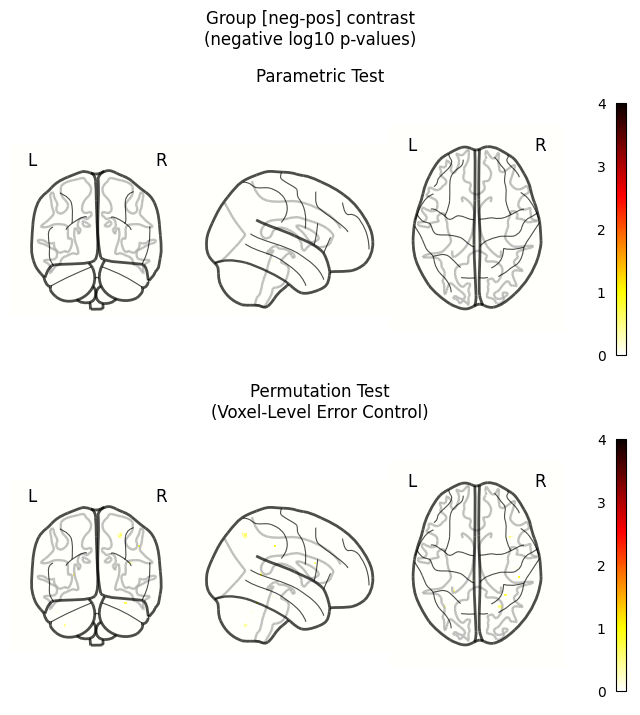

In [39]:

# Prepare thresholds for plotting

threshold_log = round(-np.log10(1 / 20))  # p < 0.05 
vmax = round(-np.log10(1 / n_perm)) # minimal p-value possible with the number of permuations

cut_coords = [0]


#Prepare images to plot
IMAGES = [
    neg_log_pval,
    out_dict
]
TITLES = [
    'Parametric Test',
    'Permutation Test\n(Voxel-Level Error Control)',
]

#Make loop with plots
fig, axes = plt.subplots(figsize=(8, 8), nrows=2, ncols=1)
img_counter = 0
i_row=0
for j_row in range(2):
        ax = axes[j_row]     
        plotting.plot_glass_brain(
            IMAGES[img_counter],
            colorbar=True,
            vmax=vmax,
            plot_abs=False,
            cut_coords=cut_coords,
            threshold=None,#threshold_log,
            figure=fig,
            axes=ax,
        )

        
        ax.set_title(TITLES[img_counter])
        img_counter += 1


fig.suptitle('Group [neg-pos] contrast\n(negative log10 p-values)')
plt.show()

### Publish!!!

We have a result. We are almost ready for publication. All we need to know is what it means... 

In [ ]:
now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))